In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from relbench.datasets import get_dataset

import utils

%load_ext autoreload
%autoreload 2

# graphs too large for interactivity
pio.renderers.default = 'svg'

In [2]:
dataset = get_dataset(name='rel-stackex', process=True)

making Database object from raw files...
done in 28.51 seconds.
reindexing pkeys and fkeys...
done in 1.33 seconds.


In [3]:
dataset.db.table_dict.keys()

dict_keys(['comments', 'badges', 'postLinks', 'postHistory', 'votes', 'users', 'posts'])

#### Schema:
[Full Schema](https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede/2678#2678)

![|500](https://relbench.stanford.edu/img/stack-exchange.png)

## Tasks

### `rel-stackex-engage`

Task is to predict if a user will make any engagement (vote, comment or post) on the site in the
next 2 years.

Filter: users who have made at least one comment/post/vote before the timestamp

ML task: Binary Classification

Evaluation Metric: AP

In [4]:
task = dataset.get_task('rel-stackex-engage', process=True)

In [5]:
task.train_table.df.columns

Index(['timestamp', 'OwnerUserId', 'contribution'], dtype='object')

In [6]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.OwnerUserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.train_table.df.contribution.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='OwnerUserId', keep='last')
    .groupby('timestamp').OwnerUserId.nunique() / task.train_table.df.OwnerUserId.nunique()
)

TRAIN

1,360,850 samples over 83,531 users.

Label Distribution:
contribution
0    0.950017
1    0.049983
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2009-04    0.000004
2009-07    0.000004
2009-10    0.000004
2010-01    0.000005
2010-04    0.000005
2010-07    0.000007
2010-10    0.000380
2011-01    0.000617
2011-04    0.000977
2011-07    0.001402
2011-10    0.001892
2012-01    0.002472
2012-04    0.003224
2012-07    0.003944
2012-10    0.004790
2013-01    0.005738
2013-04    0.006918
2013-07    0.008120
2013-10    0.009299
2014-01    0.010476
2014-04    0.012057
2014-07    0.013626
2014-10    0.015179
2015-01    0.016758
2015-04    0.018542
2015-07    0.020489
2015-10    0.022444
2016-01    0.024302
2016-04    0.026307
2016-07    0.028338
2016-10    0.030435
2017-01    0.032795
2017-04    0.035161
2017-07    0.037468
2017-10    0.039523
2018-01    0.041490
2018-04    0.043539
2018-07    0.045733
2018-10    0.047604
2019-01    0.049432
2019-04    0.051696
2019

In [7]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.OwnerUserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.val_table.df.contribution.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'User overlap between train and val: {len(set(task.train_table.df.OwnerUserId) & set(task.val_table.df.OwnerUserId)):,}')

VAL

85,838 samples over 85,838 users.

Label Distribution:
contribution
0    0.971912
1    0.028088
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2020-10    1.0
Name: proportion, dtype: float64

User overlap between train and val: 83,531


**Notes**:

- `timestamp` is chopped up into two-year chunks rather than a finer grain (which would yield more samples per user)
- Train-val split is temporal
- Val is almost as large as train -- reflects the growth of the platform probably. Number of samples (& users) biased towards recent years.
- All users in train appear in val -- when evaluating look at performance diff b/w in-train and out-of-train user sets.

### `rel-stackex-votes`

Task is to predict if the number of upvotes a question will get in the following 6 months.

Filter: questions older than 2 years before timestamp to avoid predictions on stale questions.

ML task: Regression

Evaluation Metric: MAE

In [8]:
task = dataset.get_task('rel-stackex-votes', process=True)

In [9]:
task.train_table.df.columns

Index(['timestamp', 'PostId', 'popularity'], dtype='object')

TRAIN

2,453,921 samples over 151,161 posts.

Temporal dist of samples:
timestamp
2009-04    4.075111e-07
2009-07    4.075111e-07
2009-10    4.075111e-07
2010-01    4.075111e-07
2010-04    4.075111e-07
2010-07    8.150222e-07
2010-10    3.068558e-04
2011-01    5.733681e-04
2011-04    9.605036e-04
2011-07    1.436884e-03
2011-10    1.968686e-03
2012-01    2.524531e-03
2012-04    3.275167e-03
2012-07    4.061663e-03
2012-10    4.903173e-03
2013-01    5.828631e-03
2013-04    6.904053e-03
2013-07    8.110693e-03
2013-10    9.346674e-03
2014-01    1.052846e-02
2014-04    1.212631e-02
2014-07    1.377021e-02
2014-10    1.531345e-02
2015-01    1.691293e-02
2015-04    1.873084e-02
2015-07    2.069586e-02
2015-10    2.254963e-02
2016-01    2.439321e-02
2016-04    2.638797e-02
2016-07    2.839456e-02
2016-10    3.045045e-02
2017-01    3.271743e-02
2017-04    3.517187e-02
2017-07    3.738303e-02
2017-10    3.935416e-02
2018-01    4.129147e-02
2018-04    4.335266e-02
2018-07    4.551654e-02
2018-1

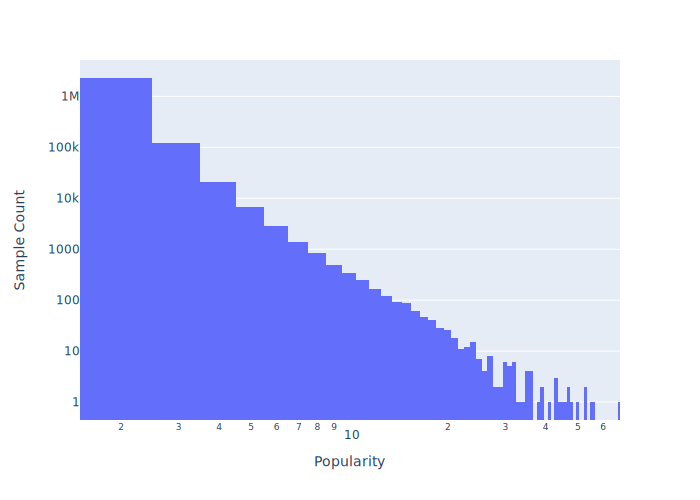

In [10]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.PostId.nunique():,} posts.')
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of posts (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='PostId', keep='last')
    .groupby('timestamp').PostId.nunique() / task.train_table.df.PostId.nunique()
)
print()
print('Label Distribution:')
mean = task.train_table.df.popularity.mean()
std = task.train_table.df.popularity.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Median: {task.train_table.df.popularity.quantile(0.5)}')
print(f'Prop zeros: {(task.train_table.df.popularity == 0).mean():.1%}')
fig = px.histogram(x=task.train_table.df.popularity + 1, log_x=True, log_y=True)
# ^-- add 1 so log scale shows
fig.update_layout(xaxis_title='Popularity', yaxis_title='Sample Count')

VAL

156,216 samples over 156,216 posts.

Temporal dist of samples:
timestamp
2020-10    1.0
Name: proportion, dtype: float64

Temporal dist of posts (first appearance):
timestamp
2020-10-01    1.0
Name: PostId, dtype: float64

Label Distribution:
Mean (std): 0.1 ± 0.4
Median: 0.0
Prop zeros: 95.2%


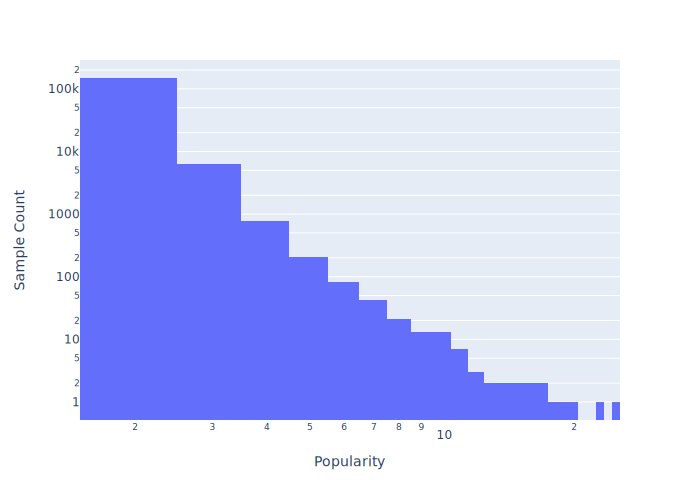

In [11]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.PostId.nunique():,} posts.')
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of posts (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.val_table.df
    .drop_duplicates(subset='PostId', keep='last')
    .groupby('timestamp').PostId.nunique() / task.val_table.df.PostId.nunique()
)
print()
print('Label Distribution:')
mean = task.val_table.df.popularity.mean()
std = task.val_table.df.popularity.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Median: {task.val_table.df.popularity.quantile(0.5)}')
print(f'Prop zeros: {(task.val_table.df.popularity == 0).mean():.1%}')
fig = px.histogram(x=task.val_table.df.popularity + 1, log_x=True, log_y=True)
# ^-- add 1 so log scale shows
fig.update_layout(xaxis_title='Popularity', yaxis_title='Sample Count')

**Notes**:
- Label is incredibly skewed (vast majority of labels are 0)
- Will be hard to learn a good model --> could consider just doing classfication (0 vs nonzero) + some regression on the nonzero part

### `rel-stackex-badges`

TODO Fill out
Task is to predict if the number of upvotes a question will get in the following 6 months.

Filter: questions older than 2 years before timestamp to avoid predictions on stale questions.

ML task: Binary Classification

Evaluation Metric: AUC?

In [12]:
task = dataset.get_task('rel-stackex-badges', process=True)

In [13]:
task.train_table.df.columns

Index(['timestamp', 'UserId', 'WillGetBadge'], dtype='object')

In [14]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.UserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.train_table.df.WillGetBadge.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='UserId', keep='last')
    .groupby('timestamp').UserId.nunique() / task.train_table.df.UserId.nunique()
)

TRAIN

3,386,276 samples over 239,945 users.

Label Distribution:
WillGetBadge
0    0.95185
1    0.04815
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2010-10    0.000323
2011-01    0.000520
2011-04    0.000770
2011-07    0.001071
2011-10    0.001420
2012-01    0.001839
2012-04    0.002353
2012-07    0.002852
2012-10    0.003403
2013-01    0.004063
2013-04    0.004941
2013-07    0.005843
2013-10    0.006657
2014-01    0.007558
2014-04    0.008908
2014-07    0.010191
2014-10    0.011463
2015-01    0.012845
2015-04    0.014457
2015-07    0.016235
2015-10    0.018030
2016-01    0.019934
2016-04    0.022254
2016-07    0.024566
2016-10    0.026948
2017-01    0.029916
2017-04    0.033358
2017-07    0.036767
2017-10    0.039840
2018-01    0.042986
2018-04    0.046393
2018-07    0.049469
2018-10    0.052043
2019-01    0.054774
2019-04    0.057856
2019-07    0.060532
2019-10    0.062801
2020-01    0.065215
2020-04    0.067747
2020-07    0.070858
Name: proportion, dtype: 

In [15]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.UserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.val_table.df.WillGetBadge.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.val_table.df
    .drop_duplicates(subset='UserId', keep='last')
    .groupby('timestamp').UserId.nunique() / task.val_table.df.UserId.nunique()
)

VAL

247,398 samples over 247,398 users.

Label Distribution:
WillGetBadge
0    0.970489
1    0.029511
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2020-10    1.0
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2020-10-01    1.0
Name: UserId, dtype: float64


## Raw Data

### Users

In [16]:
users = dataset.db.table_dict['users'].df

In [17]:
users.head()

,Id,AccountId,DisplayName,Location,ProfileImageUrl,WebsiteUrl,AboutMe,CreationDate
0,0,-1.0,Community,on the server farm,NaN,http://meta.stackexchange.com/,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",2010-07-19 06:55:26.860
1,1,2.0,Geoff Dalgas,"Corvallis, OR",NaN,http://stackoverflow.com,<p>Dev #2 who helped create Stack Overflow cur...,2010-07-19 14:01:36.697
2,2,3.0,Jarrod Dixon,"Johnson City, TN, USA",NaN,http://jarroddixon.com,"<p>Former <a href=""http://blog.stackoverflow.c...",2010-07-19 15:34:50.507
3,3,1998.0,Emmett,"San Francisco, CA",NaN,http://minesweeperonline.com,"<p>co-founder of <a href=""https://airtable.com...",2010-07-19 19:03:27.400
4,4,54503.0,Shane,"New York, NY",NaN,http://www.statalgo.com,<p>Quantitative researcher focusing on statist...,2010-07-19 19:03:57.227


In [18]:
# Check NaNs
users.isna().mean()

Id                 0.000000
AccountId          0.000047
DisplayName        0.000074
Location           0.721276
ProfileImageUrl    1.000000
WebsiteUrl         0.889431
AboutMe            0.805435
CreationDate       0.000000
dtype: float64

In [19]:
users.Location.apply(lambda x: str(x).split(',')[-1].strip()).value_counts(normalize=True)

Location
nan                                       0.721276
India                                     0.028058
United States                             0.024483
USA                                       0.022697
Germany                                   0.012962
                                            ...   
Somewhere between earth and andromeda.    0.000004
Europe/Berlin                             0.000004
University of Tsukuba                     0.000004
None of your business                     0.000004
73.5164664                                0.000004
Name: proportion, Length: 3535, dtype: float64

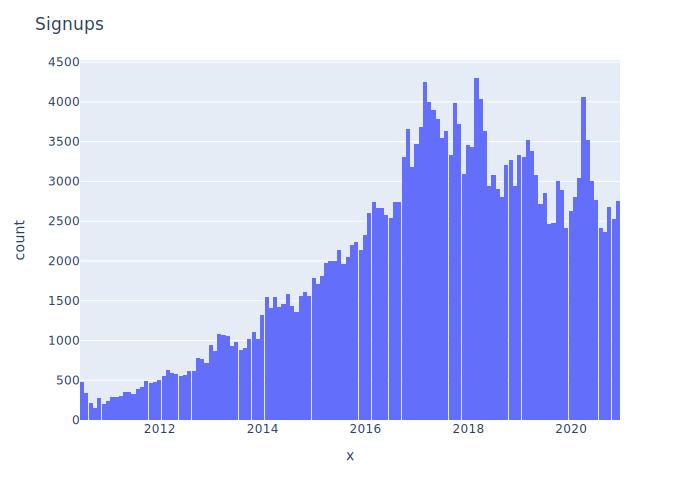

In [20]:
fig = px.histogram(x=users.CreationDate.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='Signups')

**Notes**:
- Some obvious features related to NaNs: eg nan aboutMe, nan location, nan website
- Use creation date for months_since_creation
- Would be nice to know when they edited profile last.
- Seasonal dip in signups in July/August (maybe b/c school's out!) -- check if seasonality extends to posts too

### Badges

In [21]:
badges = dataset.db.table_dict['badges'].df

In [22]:
badges.sample(n=15)

,Id,UserId,Class,Name,TagBased,Date
94028,94028,24715,3,Curious,False,2014-12-20 01:18:24.013
428865,428865,235285,3,Supporter,False,2020-05-17 18:40:07.600
71469,71469,6854,3,Curious,False,2014-07-02 16:05:34.963
434563,434563,43493,2,Yearling,False,2020-06-22 23:32:18.797
190538,190538,16671,2,Notable Question,False,2016-10-07 12:16:52.093
377561,377561,207396,3,Informed,False,2019-07-30 14:55:03.360
416014,416014,39127,2,Yearling,False,2020-03-04 19:25:27.453
144367,144367,66602,3,Supporter,False,2015-12-21 04:10:49.877
339254,339254,183912,3,Autobiographer,False,2018-12-15 00:25:02.620
358008,358008,114946,3,Teacher,False,2019-03-30 21:35:28.003


In [23]:
badges.isna().mean()

Id          0.0
UserId      0.0
Class       0.0
Name        0.0
TagBased    0.0
Date        0.0
dtype: float64

In [24]:
badges.TagBased.value_counts(normalize=True)

TagBased
False    0.996641
True     0.003359
Name: proportion, dtype: float64

In [25]:
badges.Name.value_counts(normalize=True)

Name
Student                 0.131756
Autobiographer          0.109443
Supporter               0.096625
Editor                  0.094450
Popular Question        0.082179
                          ...   
entropy                 0.000002
discrete-data           0.000002
wilcoxon-signed-rank    0.000002
survey                  0.000002
fixed-effects-model     0.000002
Name: proportion, Length: 327, dtype: float64

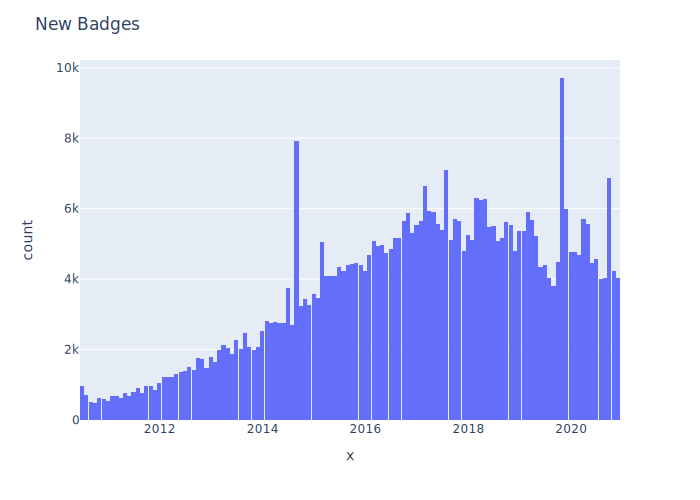

In [26]:
fig = px.histogram(x=badges.Date.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='New Badges')

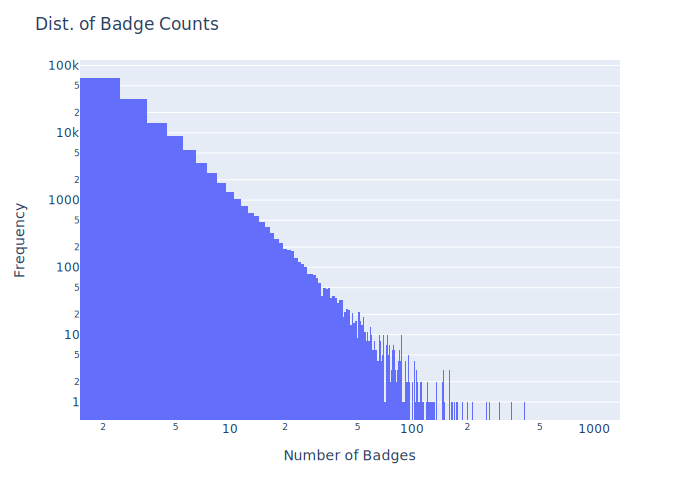

In [27]:
# Distribution of num tags
fig = px.histogram(x=badges.groupby('UserId').size(), log_x=True, log_y=True)
fig.update_layout(height=500, width=700, title='Dist. of Badge Counts',
                  xaxis_title='Number of Badges', yaxis_title='Frequency')

**Notes**
- Same seasonality observed (summer lull)
- The number of badges by user obeys a power law
- Can probably aggregate a users badges into a single feature that captures the sum total of their badges weighted by rarity
- Interesting to look at time since last badge and rarity of last badge by user

### Posts

In [28]:
posts = dataset.db.table_dict['posts'].df
print(f'Total Posts: {len(posts):,}')

Total Posts: 333,893


In [29]:
posts.sample(n=15)

,Id,OwnerUserId,PostTypeId,AcceptedAnswerId,ParentId,OwnerDisplayName,Title,Tags,ContentLicense,Body,CreationDate
252534,252534,111766,1,<NA>,<NA>,NaN,Recommended model to analyze relationship with...,<regression><generalized-linear-model><python>...,CC BY-SA 4.0,<p>In order to analyze the relationship betwee...,2018-12-01 11:12:25.647
153837,153837,81916,1,153841,<NA>,NaN,Too many variables and multicollinearity in OL...,<regression><multiple-regression><least-square...,CC BY-SA 3.0,"<p>After reading material related to my topic,...",2016-07-15 17:48:23.117
72269,72269,11860,1,72342,<NA>,NaN,How to measure multichannel distances between ...,<traminer><sequence-analysis>,CC BY-SA 3.0,"<p>In TraMineR, seqdistmc is used to measure m...",2014-04-18 12:27:43.140
305981,305981,231791,1,<NA>,<NA>,NaN,Is a time trend a substitute for first differe...,<regression><time-series><trend><differences>,CC BY-SA 4.0,<p>I am doing a macroeconomic analysis involvi...,2020-04-20 08:54:52.873
325975,325975,199514,2,<NA>,325965,NaN,NaN,NaN,CC BY-SA 4.0,<p>I think this just means that K is the targe...,2020-10-10 10:27:59.347
104849,104849,39254,2,<NA>,104846,NaN,NaN,NaN,CC BY-SA 3.0,<p>To think about ways to infer whether your d...,2015-04-07 15:11:27.073
76454,76454,32595,2,<NA>,26566,NaN,NaN,NaN,CC BY-SA 3.0,"<p>Similar to Weka, you may also try <a href=""...",2014-06-01 01:29:40.760
230978,230978,9081,2,<NA>,138447,NaN,NaN,NaN,CC BY-SA 4.0,"<p>As pointed out in comments, this is a stand...",2018-05-12 13:51:47.810
84645,84645,37001,1,<NA>,<NA>,NaN,Classification tips for a begginer,<classification><predictive-models><prediction...,CC BY-SA 3.0,<p>I'm doing a graduation work that involves a...,2014-08-29 20:30:38.780
180223,180223,1145,2,<NA>,180221,NaN,NaN,NaN,CC BY-SA 3.0,<p>(I'm assuming this is a self-study question...,2017-02-26 01:43:09.663


In [30]:
posts.PostTypeId.value_counts(normalize=True)

PostTypeId
2    0.501223
1    0.490421
5    0.004127
4    0.004127
6    0.000069
3    0.000018
7    0.000015
Name: proportion, dtype: float64

In [31]:
posts.ContentLicense.value_counts(normalize=True)

ContentLicense
CC BY-SA 3.0    0.635656
CC BY-SA 4.0    0.343544
CC BY-SA 2.5    0.020800
Name: proportion, dtype: float64

In [32]:
posts.isna().mean()

Id                  0.000000
OwnerUserId         0.015709
PostTypeId          0.000000
AcceptedAnswerId    0.827148
ParentId            0.498777
OwnerDisplayName    0.974402
Title               0.509579
Tags                0.509579
ContentLicense      0.000000
Body                0.001477
CreationDate        0.000000
dtype: float64

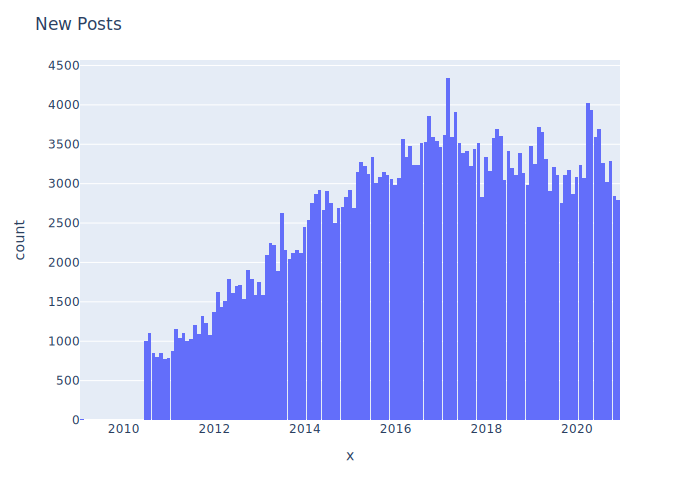

In [33]:
fig = px.histogram(x=posts.CreationDate.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='New Posts')

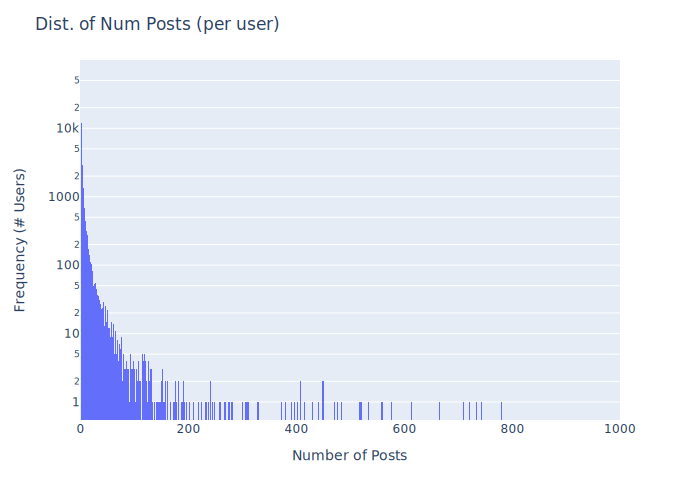

In [34]:
fig = px.histogram(x=posts.groupby('OwnerUserId').size(), log_y=True, range_x=(0, 1000))
fig.update_traces(xbins=dict( # bins used for histogram
        start=0,
        end=1000,
        size=1
    ))
fig.update_layout(height=500, width=700, title='Dist. of Num Posts (per user)',
                  xaxis_title='Number of Posts', yaxis_title='Frequency (# Users)')

In [35]:
num_answers = posts.groupby('ParentId').size()
# posts.set_index('Id', inplace=True)
posts.loc[num_answers.index, 'num_answers'] = num_answers.values
posts['num_answers'].fillna(0, inplace=True)

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_14503/776345772.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_14503/776345772.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/08/91_vkqq52qg5phplpc

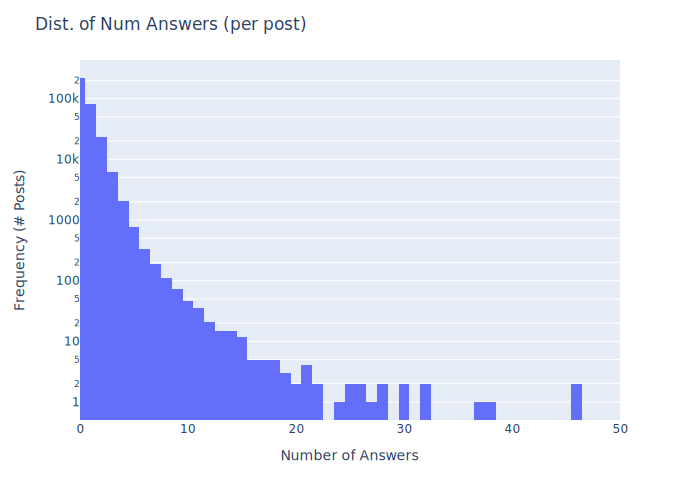

In [36]:
fig = px.histogram(posts, x='num_answers', log_y=True, range_x=(0, 50))
fig.update_layout(height=500, width=700, title='Dist. of Num Answers (per post)',
                  xaxis_title='Number of Answers', yaxis_title='Frequency (# Posts)')

In [37]:
posts['post_length'] = posts.Body.str.len()

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_14503/3049498844.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



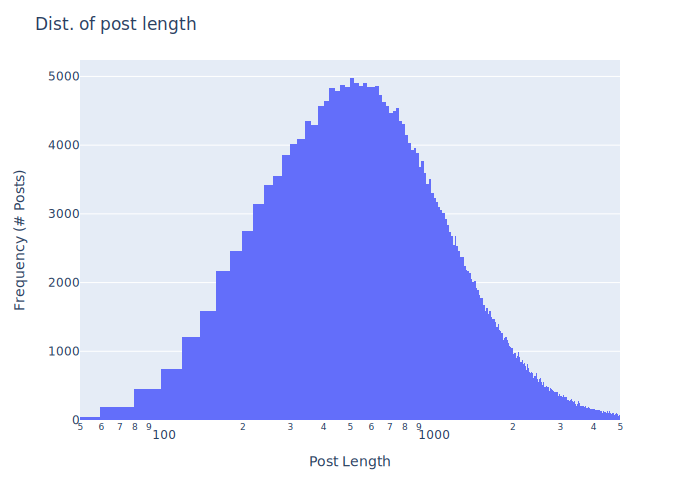

In [38]:
fig = px.histogram(posts, x='post_length', log_x=True, range_x=(50, 5_000))
fig.update_layout(height=500, width=700, title='Dist. of post length',
                  xaxis_title='Post Length', yaxis_title='Frequency (# Posts)')

In [39]:
# posts per user over time
posts_per_user = (
    posts.groupby(posts.CreationDate.dt.strftime('%Y-%m')).size()
    / users.groupby(users.CreationDate.dt.strftime('%Y-%m')).size().cumsum()
)

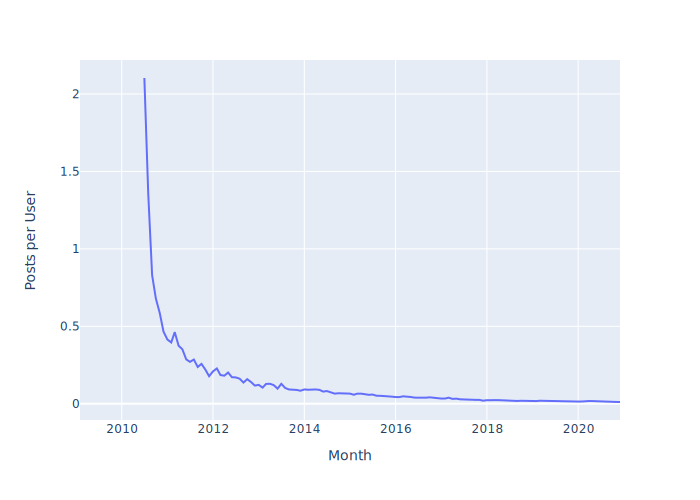

In [40]:
fig = px.line(x=posts_per_user.index, y=posts_per_user.values, width=700, height=500)
fig.update_layout(xaxis_title='Month', yaxis_title='Posts per User')

In [41]:
def get_tag_list(tag_str: str) -> list[str]:
    return tag_str.strip('<>').split('><')

print(get_tag_list('<elementary-set-theory><intuition><infinity><faq>'))
print(get_tag_list('<computer-science>'))

['elementary-set-theory', 'intuition', 'infinity', 'faq']
['computer-science']


In [42]:
posts.Tags.head()

0    <terminology><outliers><types-of-averages>
1                                           NaN
2                                           NaN
3                                           NaN
4                                           NaN
Name: Tags, dtype: object

**Notes**
- Seasonality preserved.
- Power laws in number of posts (per user) and number of answers (per post)
- Post length has interesting dist (may be informative for churn?)
- Tags likely not informative (gut feeling is that signal will have been captured in other feats.)
- Post rate per user goes down because of churn (interesting to look at per active user w/ more time).
- Can focus solely on questions (type == 1) and answers (type == 2), other types are too rare.

### PostHistory

In [43]:
post_hist = dataset.db.table_dict['postHistory'].df
print(f'Total Post History records: {len(post_hist):,}')

Total Post History records: 1,175,368


In [44]:
post_hist.PostHistoryTypeId.value_counts(normalize=True)

PostHistoryTypeId
2     0.284075
5     0.241287
1     0.140121
3     0.139316
6     0.045889
4     0.034354
50    0.033510
25    0.023582
24    0.019541
10    0.011811
33    0.004759
16    0.004292
34    0.004202
36    0.003545
11    0.002157
12    0.001900
13    0.001900
52    0.001231
8     0.000533
19    0.000522
38    0.000474
14    0.000396
37    0.000185
7     0.000151
9     0.000134
15    0.000092
35    0.000035
20    0.000003
53    0.000003
Name: proportion, dtype: float64

In [45]:
# posts closed or deleted
post_hist[post_hist.PostHistoryTypeId.isin({10, 12})].PostId.nunique()

15575

In [46]:
# post tweeted
post_hist[post_hist.PostHistoryTypeId == 25].PostId.nunique()

27717

### Votes

In [47]:
votes = dataset.db.table_dict['votes'].df
print(f'Total votes: {len(votes):,}')

Total votes: 1,317,876


In [48]:
votes.isna().mean()

Id              0.000000
UserId          0.996068
PostId          0.089572
VoteTypeId      0.000000
CreationDate    0.000000
dtype: float64

In [49]:
# see full schema for type descriptions
votes['is_positive'] = votes.VoteTypeId.isin({1, 2, 5, 8, 16})
votes['is_negative'] = votes.VoteTypeId.isin({3, 4, 6, 10, 12})

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_14503/3146523349.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_14503/3146523349.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



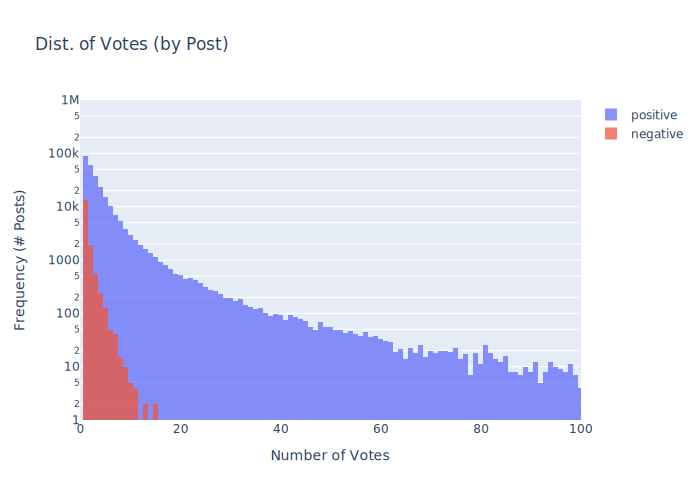

In [50]:
fig = go.Figure(
    [
            go.Histogram(x=votes[votes.is_positive].groupby('PostId').size(), name='positive', ),
            go.Histogram(x=votes[votes.is_negative].groupby('PostId').size(), name='negative')
    ],
    layout=dict(barmode='overlay')
)
# fig = px.histogram(x=votes[votes.is_positive].groupby('PostId').size(), log_y=True, range_x=(0, 100))
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log", range=[0, 6])
fig.update_xaxes(range=[0, 100])
fig.update_layout(height=500, width=700, title='Dist. of Votes (by Post)',
                  xaxis_title='Number of Votes', yaxis_title='Frequency (# Posts)')

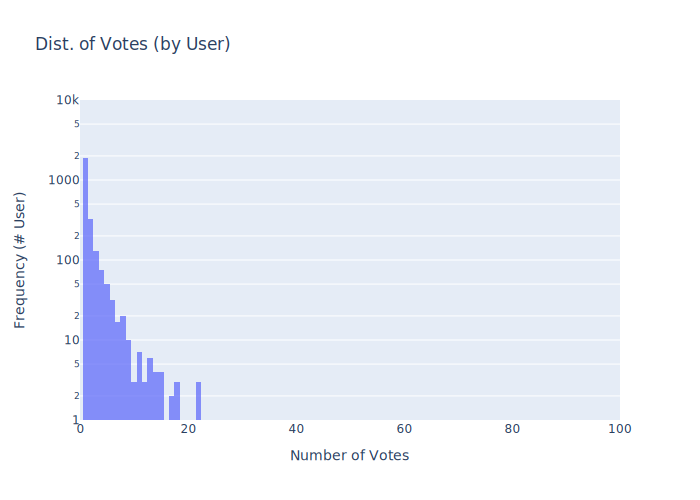

In [51]:
fig = go.Figure(
    [
            go.Histogram(x=votes[votes.is_positive].groupby('UserId').size(), name='positive'),
            go.Histogram(x=votes[votes.is_negative].groupby('UserId').size(), name='negative')
    ],
    layout=dict(barmode='overlay')
)
# fig = px.histogram(x=votes[votes.is_positive].groupby('PostId').size(), log_y=True, range_x=(0, 100))
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log", range=[0, 4])
fig.update_xaxes(range=[0, 100])
fig.update_layout(height=500, width=700, title='Dist. of Votes (by User)',
                  xaxis_title='Number of Votes', yaxis_title='Frequency (# User)')

In [52]:
votes[votes.is_negative].UserId.isna().mean()

1.0

**Notes**:
- `UserId` is only present for `VoteTypeId` 5, 6, 7, 8 (unsure why) -- so user level feats only possible w/ positive votes
- "positive" engagements are more common (per post) than negative engagements
- Look at comment rate (ie comments per week/month)

### Comments

In [53]:
comments = dataset.db.table_dict['comments'].df
print(f'Total comments: {len(comments):,}')

Total comments: 623,967


In [54]:
comments.isna().mean()

Id                 0.000000
PostId             0.000008
UserId             0.018717
ContentLicense     0.000000
UserDisplayName    0.981271
Text               0.000000
CreationDate       0.000000
dtype: float64

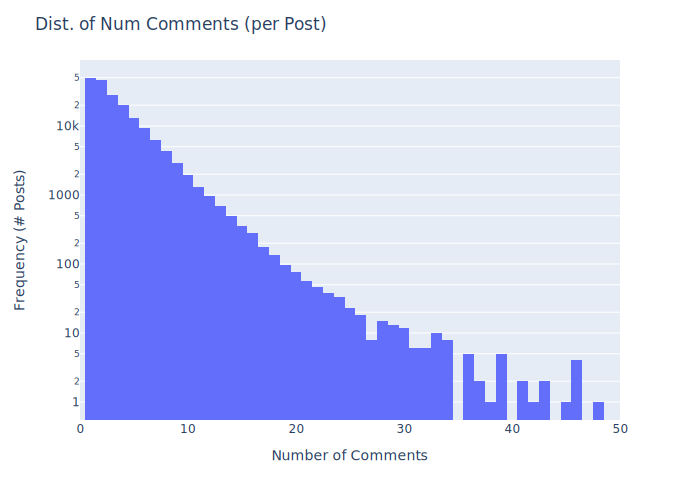

In [55]:
fig = px.histogram(x=comments.groupby('PostId').size(), log_y=True, range_x=(0, 50))
fig.update_layout(height=500, width=700, title='Dist. of Num Comments (per Post)',
                  xaxis_title='Number of Comments', yaxis_title='Frequency (# Posts)')

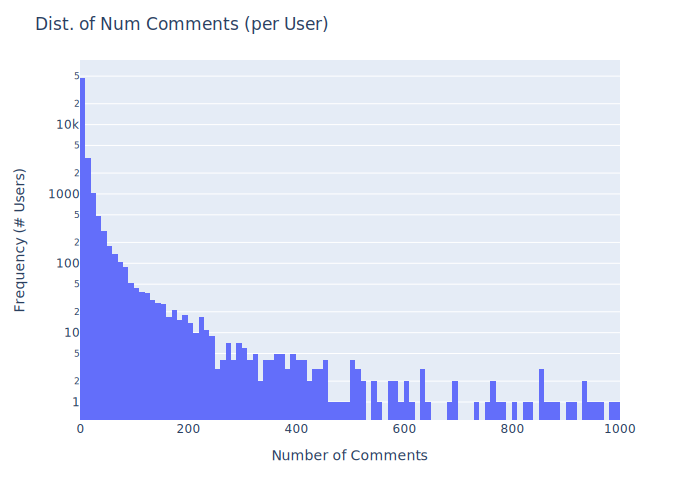

In [56]:
fig = px.histogram(x=comments.groupby('UserId').size(), log_y=True, range_x=(0, 1000))
fig.update_layout(height=500, width=700, title='Dist. of Num Comments (per User)',
                  xaxis_title='Number of Comments', yaxis_title='Frequency (# Users)')